# Calculating cohesion metrics from Herren and McMahon (2017), ISME J

In [1]:
library(ggplot2)

In [2]:
ps = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
ps

Loading required package: phyloseq


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20020 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 20020 taxa by 7 taxonomic ranks ]

In [3]:
ps.norm = transform_sample_counts(ps, function(x) x / sum(x) )
# Transforming the sample counts to relative abundances

In [4]:
# Online script to generate cohesion metrics for a set of samples 
# CMH 26Apr17; cherren@wisc.edu

# User instructions: read in a sample table (in absolute or relative abundance) as object "b".
# If using a custom correlation matrix, read in that matrix at the designated line.
# Run the entire script, and the 4 vectors (2 of connectedness and 2 of cohesion) are generated for each sample at the end.
# Parameters that can be adjusted include pers.cutoff (persistence cutoff for retaining taxa in analysis), iter (number of iterations for the null model), tax.shuffle (whether to use taxon shuffle or row shuffle randomization), and use.custom.cors (whether to use a pre-determined correlation matrix)

####################create necessary functions######################

#find the number of zeroes in a vector
zero <- function(vec){
  num.zero <- length(which(vec == 0))
  return(num.zero)
}

#create function that averages only negative values in a vector
neg.mean <- function(vector){
  neg.vals <- vector[which(vector < 0)]
  n.mean <- mean(neg.vals)
  if(length(neg.vals) == 0) n.mean <- 0
  return(n.mean)
}

#create function that averages only positive values in a vector
pos.mean <- function(vector){
  pos.vals <- vector[which(vector > 0)]
  p.mean <- mean(pos.vals)
  if(length(pos.vals) == 0) p.mean <- 0
  return(p.mean)
}

In [5]:
###################################################################
###################################################################
### Workflow options ####
###################################################################
###################################################################

## Choose a persistence cutoff (min. fraction of taxon presence) for retaining taxa in the analysis
pers.cutoff = 0.4

# From SI notes: The cohesion R script includes a parameter (pers.cutoff) to exclude taxa from the analysis 
# if they are present in fewer than a specified proportion of samples. 
# The purpose of this parameter is to exclude taxa for which reliable correlations 
# cannot be calculated. As a guideline, taxa should be present in at least 5-10 samples to be 
# included in the analysis. Thus, if your dataset has 50 samples, the pers.cutoff parameter 
# might initially be set to 0.1, as to exclude taxa present in fewer than 5 samples.

# Since we have 100 samples (if analyzing whole dataset together), if we want at least 5 samples,
# we can use pers.cutoff = 0.05

# They also recommend considering an abundance threshold cutoff, 
# such that it excludes maybe 5-10% of the total community abundance (but many more taxa).
# This will reduce compute time.

## Decide the number of iterations to run for each taxon. (>= 200 is recommended)
# Larger values of iter mean the script takes longer to run
iter = 40
# They suggest for parameterizing it, you start with 40, then use 200 for full dataset.


## Decide whether to use taxon/column shuffle (tax.shuffle = T) or row shuffle algorithm (tax.shuffle = F)
tax.shuffle = FALSE

# They found that the row shuffle null model worked better as sample evenness increased.
# Conversely, the column shuffle null model worked better when there were taxa that consistently 
# comprised > 20% of the community. In these cases, it was important to maintain taxon mean 
# abundances in the null model, which only occurs in the taxon/column shuffle null model.

# Our samples do not necessarily have high evenness - long tail. In some samples, one taxon is 20% or more
# But that's not the same taxon across samples. Will start with row shuffle

## Option to input your own correlation table
# Note that your correlation table MUST have the same number of taxa as the abundance table. There should be no empty (all zero) taxon vectors in the abundance table. 
# Even if you input your own correlation table, the persistence cutoff will be applied
use.custom.cors = F

In [6]:
###################################################################
###################################################################

# Read in dataset
## Data should be in a matrix where each row is a sample. 
# b <- read.csv("your_path_here.csv", header = T, row.names = 1)
b = otu_table(ps.norm)

# Read in custom correlation matrix, if desired. Must set "use.custom.cors" to TRUE
if(use.custom.cors == T) {
  custom.cor.mat <- read.csv("your_path_here.csv", header = T, row.names = 1)
  custom.cor.mat <- as.matrix(custom.cor.mat)
  #Check that correlation matrix and abundance matrix have the same dimension
  print(dim(b)[2] == dim(custom.cor.mat)[2])
}


# Suggested steps to re-format data. At the end of these steps, the data should be in a matrix "c" where there are no empty samples or blank taxon columns. 
c <- as.matrix(b)
c <- c[rowSums(c) > 0, colSums(c) > 0]

# Save total number of individuals in each sample in the original matrix. This will be 1 if data are in relative abundance, but not if matrix c is count data
rowsums.orig <- rowSums(c)

# Based on persistence cutoff, define a cutoff for the number of zeroes allowed in a taxon's distribution
zero.cutoff <- ceiling(pers.cutoff * dim(c)[1])
  
# Remove taxa that are below the persistence cutoff
d <- c[ , apply(c, 2, zero) < (dim(c)[1]-zero.cutoff) ]
# Remove any samples that no longer have any individuals, due to removing taxa
d <- d[rowSums(d) > 0, ]

#If using custom correlation matrix, need to remove rows/columns corresponding to the taxa below persistence cutoff
if(use.custom.cors == T){
  custom.cor.mat.sub <- custom.cor.mat[apply(c, 2, zero) < (dim(c)[1]-zero.cutoff), apply(c, 2, zero) < (dim(c)[1]-zero.cutoff)]
}

d = as.matrix(data.frame(d))
# Because otherwise it persisted as an otu table object type

In [7]:
dim(d)
# Number of taxa and samples being considered

[1] 102 107

In [8]:
# Create relative abundance matrix.  
rel.d = d / rowsums.orig
# Optionally, check to see what proportion of the community is retained after cutting out taxa
#hist(rowSums(rel.d))

# Create observed correlation matrix
cor.mat.true <- cor(rel.d)

# Create vector to hold median otu-otu correlations for initial otu
med.tax.cors <- vector()

In [9]:
# Run this loop for the null model to get expected pairwise correlations
# Bypass null model if the option to input custom correlation matrix is TRUE
if(use.custom.cors == F) {
ifelse(tax.shuffle, {
  for(which.taxon in 1:dim(rel.d)[2]){
    
    #create vector to hold correlations from every permutation for each single otu
    ## perm.cor.vec.mat stands for permuted correlations vector matrix
    perm.cor.vec.mat <- vector()
    
    for(i in 1:iter){
      #Create empty matrix of same dimension as rel.d
      perm.rel.d <- matrix(numeric(0), dim(rel.d)[1], dim(rel.d)[2])
      rownames(perm.rel.d) <- rownames(rel.d)
      colnames(perm.rel.d) <- colnames(rel.d)
      
      #For each otu
      for(j in 1:dim(rel.d)[2]){ 
        # Replace the original taxon vector with a permuted taxon vector
        perm.rel.d[, j ] <- sample(rel.d[ ,j ]) 
      }
      
      # Do not randomize focal column 
      perm.rel.d[, which.taxon] <- rel.d[ , which.taxon]
      
      # Calculate correlation matrix of permuted matrix
      cor.mat.null <- cor(perm.rel.d)
      
      # For each iteration, save the vector of null matrix correlations between focal taxon and other taxa
      perm.cor.vec.mat <- cbind(perm.cor.vec.mat, cor.mat.null[, which.taxon])
      
    }
    # Save the median correlations between the focal taxon and all other taxa  
    med.tax.cors <- cbind(med.tax.cors, apply(perm.cor.vec.mat, 1, median))
    
    # For large datasets, this can be helpful to know how long this loop will run
    if(which.taxon %% 20 == 0){print(which.taxon)}
  }
} , {
  for(which.taxon in 1:dim(rel.d)[2]){
    
    #create vector to hold correlations from every permutation for each single otu
    ## perm.cor.vec.mat stands for permuted correlations vector matrix
    perm.cor.vec.mat = vector()
    
    for(i in 1:iter){
      #Create duplicate matrix to shuffle abundances
      perm.rel.d = rel.d 
      
      #For each taxon
      for(j in 1:dim(rel.d)[1]){ 
        which.replace = which(rel.d[j, ] > 0 ) 
        # if the focal taxon is greater than zero, take it out of the replacement vector, so the focal abundance stays the same
        which.replace.nonfocal = which.replace[!(which.replace %in% which.taxon)]
        
        #Replace the original taxon vector with a vector where the values greater than 0 have been randomly permuted 
        perm.rel.d[j, which.replace.nonfocal] = sample(rel.d[j, which.replace.nonfocal]) 
      }

      # Calculate correlation matrix of permuted matrix
      cor.mat.null <- cor(perm.rel.d)
      
      # For each iteration, save the vector of null matrix correlations between focal taxon and other taxa
      perm.cor.vec.mat <- cbind(perm.cor.vec.mat, cor.mat.null[, which.taxon])
      
    }
    # Save the median correlations between the focal taxon and all other taxa  
    med.tax.cors <- cbind(med.tax.cors, apply(perm.cor.vec.mat, 1, median))
    
    # For large datasets, this can be helpful to know how long this loop will run
    if(which.taxon %% 20 == 0){print(which.taxon)}
  }
 }
)
}
# This throws an error, but I'm not sure it's a problem...

[1] 20
[1] 40
[1] 60
[1] 80
[1] 100


Warning message in rep(no, length.out = length(ans)):
“'x' is NULL so the result will be NULL”

ERROR: Error in ans[!test & ok] <- rep(no, length.out = length(ans))[!test & : replacement has length zero


In [10]:
# Save observed minus expected correlations. Use custom correlations if use.custom.cors = TRUE
ifelse(use.custom.cors == T, {
  obs.exp.cors.mat <- custom.cor.mat.sub}, {
    obs.exp.cors.mat <- cor.mat.true - med.tax.cors
  }
)
  
diag(obs.exp.cors.mat) = 0

[1] 0

In [11]:
#### 
#### Produce desired vectors of connectedness and cohesion 

# Calculate connectedness by averaging positive and negative observed - expected correlations
connectedness.pos <- apply(obs.exp.cors.mat, 2, pos.mean)
connectedness.neg <- apply(obs.exp.cors.mat, 2, neg.mean)

# Calculate cohesion by multiplying the relative abundance dataset by associated connectedness
cohesion.pos <- rel.d %*% connectedness.pos
cohesion.neg <- rel.d %*% connectedness.neg

####
#### Combine vectors into one list and print 
output <- list(connectedness.neg, connectedness.pos, cohesion.neg, cohesion.pos)
names(output) <- c("Negative Connectedness", "Positive Connectedness", "Negative Cohesion", "Positive Cohesion")

print(output)

$`Negative Connectedness`
        sq1         sq2         sq3         sq4         sq5         sq6 
-0.10224777 -0.10700007 -0.08784033 -0.05073101 -0.08939495 -0.08155985 
        sq7         sq8         sq9        sq10        sq11        sq12 
-0.04931076 -0.09951430 -0.09839176 -0.04447904 -0.09193968 -0.06782423 
       sq13        sq14        sq15        sq16        sq18        sq19 
-0.10206948 -0.10021792 -0.07784567 -0.11836461 -0.07722233 -0.07005624 
       sq20        sq21        sq22        sq23        sq24        sq25 
-0.08994144 -0.05071407 -0.04575412 -0.08386001 -0.04814942 -0.10379671 
       sq26        sq27        sq28        sq29        sq31        sq33 
-0.08470801 -0.06577898 -0.09486104 -0.08281087 -0.10769978 -0.08852111 
       sq36        sq38        sq39        sq43        sq45        sq48 
-0.06947978 -0.10014547 -0.10053726 -0.08208804 -0.06711112 -0.08852717 
       sq51        sq52        sq53        sq55        sq57        sq58 
-0.10217132 -0.03966387 -

In [12]:
sample_data(ps.norm)$PositiveCohesion = output$"Positive Cohesion"
sample_data(ps.norm)$NegativeCohesion = output$"Negative Cohesion"

In [22]:
colnames(sample_data(ps.norm))

[1] "Barcodes"                  "Sample_ID"                
  [3] "Site_ID"                   "Org_or_Min"               
  [5] "Exch_Na_mg_kg"             "Exch_Mg_mg_kg"            
  [7] "Exch_K_mg_kg"              "Exch_Ca_mg_kg"            
  [9] "pH"                        "EC_mS_cm"                 
 [11] "CEC_cmol_kg"               "Total_N_pct"              
 [13] "Total_S_pct"               "Sand_pct"                 
 [15] "Clay_pct"                  "Silt_pct"                 
 [17] "Ca_mg_kg"                  "K_mg_kg"                  
 [19] "Mg_mg_kg"                  "Na_mg_kg"                 
 [21] "P_mg_kg"                   "S_mg_kg"                  
 [23] "Al_mg_kg"                  "Fe_mg_kg"                 
 [25] "Zn_mg_kg"                  "Cu_mg_kg"                 
 [27] "Mn_mg_kg"                  "Mo_mg_kg"                 
 [29] "TIC_ash_pct"               "TOC_LOI_pct"              
 [31] "TOC_HCL_cruc_pct"          "TC_pct"                   
 [33] "Fire_ID"                   "Ecosite"                  
 [35] "Moisture"                  "Moisture_Regime"          
 [37] "Nutrient"                  "Community"                
 [39] "Forest"                    "Plains"                   
 [41] "Interval"                  "Veg_Comm"                 
 [43] "Land_Class_Unburned"       "Land_Class"               
 [45] "Burned_Unburned"           "Understory_CBI"           
 [47] "Overstory_CBI"             "CBI"                      
 [49] "RBR"                       "Pct_Exposed_Mineral"      
 [51] "CFSI"                      "Burn_Severity_Index"      
 [53] "Mean_Duff_Depth_cm"        "O_Depth_cm"               
 [55] "Dead_Trees"                "Live_Trees"               
 [57] "nTrees"                    "Severity_Class"           
 [59] "temp"                      "rh"                       
 [61] "ws"                        "prec"                     
 [63] "ffmc"                      "dmc"                      
 [65] "dc"                        "isi"                      
 [67] "bui"                       "fwi"                      
 [69] "Correct_ID"                "Number_Fires_Recorded"    
 [71] "TSLF"                      "TSO"                      
 [73] "Fires_PerYear"             "Fires_PerDecade_Recording"
 [75] "Longest_Period_Btw_Fires"  "Shortest_Period_Btw_Fires"
 [77] "Mean_Period_Btw_Fires"     "Reburn_Severity_Index"    
 [79] "Overstory_Dens_ha"         "Understory_Dens_ha"       
 [81] "Abs_Density_Ha_UnderOver"  "PINUBAN_Stems_Ha"         
 [83] "PICEMAR_Stems_Ha"          "PICEGLA_Stems_Ha"         
 [85] "LARILAR_Stems_Ha"          "POPUTRE_Stems_Ha"         
 [87] "POPUBAL_Stems_Ha"          "BETUPAP_Stems_Ha"         
 [89] "PINUBAN_BA_per_Ha"         "PICEMAR_BA_per_Ha"        
 [91] "PICEGLA_BA_per_Ha"         "LARILAR_BA_per_Ha"        
 [93] "POPUTRE_BA_per_Ha"         "POPUBAL_BA_per_Ha"        
 [95] "BETUPAP_BA_per_Ha"         "BA_ha"                    
 [97] "Pct_Conifer_Stems_lar"     "Pct_Conifer_BA_lar"       
 [99] "Median_CBH"                "Flammable_T_ha"           
[101] "Conifer_CBD"               "Surface_Severity_Class"   
[103] "Soil_Class"                "PositiveCohesion"         
[105] "NegativeCohesion"

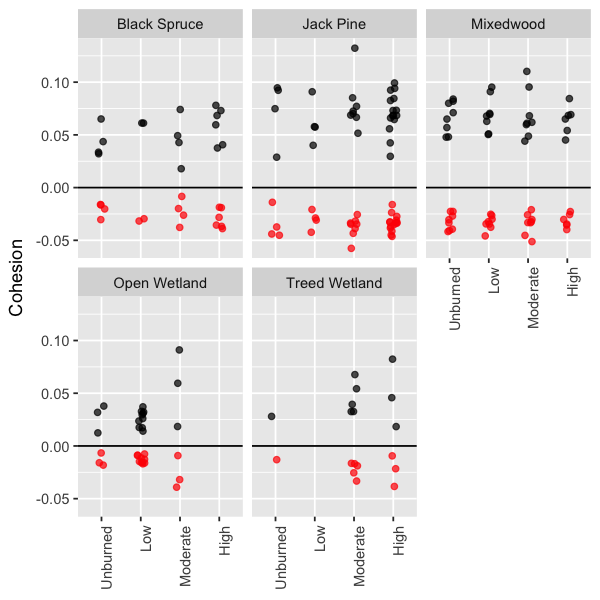

In [33]:
options(repr.plot.width=5, repr.plot.height=5)

df = data.frame(sample_data(ps.norm))

p = ggplot(df, aes(x=Severity_Class,color=Site_ID))
p = p + geom_jitter(aes(y=PositiveCohesion), color = "black",width=0.1,alpha=0.7)
p = p + geom_jitter(aes(y=NegativeCohesion), color="red",width=0.1,alpha=0.7)
#p = p + geom_jitter(aes(y=PositiveCohesion),width=0.1,alpha=0.7)
#p = p + geom_jitter(aes(y=NegativeCohesion),width=0.1,alpha=0.7)
p = p + facet_wrap(~Veg_Comm)
p = p + geom_abline(slope=0,intercept=0)
p = p + ylab("Cohesion")
p = p + theme(axis.text.x = element_text(angle=90,hjust=1),
             axis.title.x = element_blank()) + scale_colour_discrete(guide = FALSE)
p

In [ ]:
# In general, very pos sites were also very negative

Warning message:
“Ignoring unknown parameters: width”

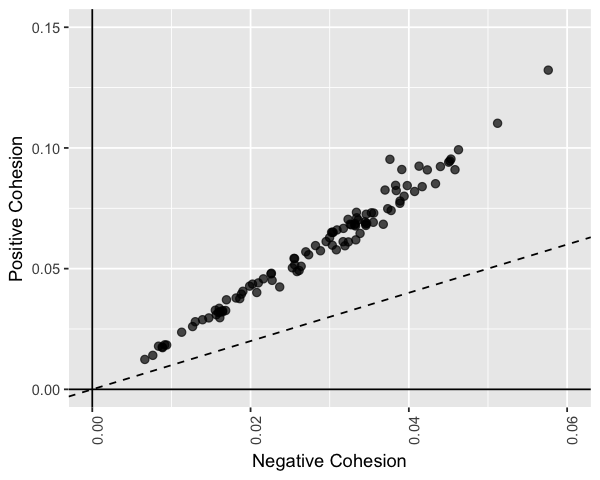

In [70]:
options(repr.plot.width=5, repr.plot.height=4)

df = data.frame(sample_data(ps.norm))
df$NegCo = df$NegativeCohesion*(-1)

p = ggplot(df)
p = p + geom_point(aes(y=PositiveCohesion,x=NegCo),width=0.1,alpha=0.7, size=2)

p = p + ylim(c(0,0.15)) + xlim(c(0,0.06))
p = p + geom_abline(slope=1,intercept=0,linetype=2)
p = p + geom_abline(slope=1000000000000000000,intercept=0)
p = p + geom_abline(slope=0,intercept=0)
p = p + ylab("Positive Cohesion") + xlab("Negative Cohesion")
p = p + theme(axis.text.x = element_text(angle=90,hjust=1),legend.title=element_blank()) 
p

In [80]:
colnames(df)

[1] "Barcodes"                  "Sample_ID"                
  [3] "Site_ID"                   "Org_or_Min"               
  [5] "Exch_Na_mg_kg"             "Exch_Mg_mg_kg"            
  [7] "Exch_K_mg_kg"              "Exch_Ca_mg_kg"            
  [9] "pH"                        "EC_mS_cm"                 
 [11] "CEC_cmol_kg"               "Total_N_pct"              
 [13] "Total_S_pct"               "Sand_pct"                 
 [15] "Clay_pct"                  "Silt_pct"                 
 [17] "Ca_mg_kg"                  "K_mg_kg"                  
 [19] "Mg_mg_kg"                  "Na_mg_kg"                 
 [21] "P_mg_kg"                   "S_mg_kg"                  
 [23] "Al_mg_kg"                  "Fe_mg_kg"                 
 [25] "Zn_mg_kg"                  "Cu_mg_kg"                 
 [27] "Mn_mg_kg"                  "Mo_mg_kg"                 
 [29] "TIC_ash_pct"               "TOC_LOI_pct"              
 [31] "TOC_HCL_cruc_pct"          "TC_pct"                   
 [33] "Fire_ID"                   "Ecosite"                  
 [35] "Moisture"                  "Moisture_Regime"          
 [37] "Nutrient"                  "Community"                
 [39] "Forest"                    "Plains"                   
 [41] "Interval"                  "Veg_Comm"                 
 [43] "Land_Class_Unburned"       "Land_Class"               
 [45] "Burned_Unburned"           "Understory_CBI"           
 [47] "Overstory_CBI"             "CBI"                      
 [49] "RBR"                       "Pct_Exposed_Mineral"      
 [51] "CFSI"                      "Burn_Severity_Index"      
 [53] "Mean_Duff_Depth_cm"        "O_Depth_cm"               
 [55] "Dead_Trees"                "Live_Trees"               
 [57] "nTrees"                    "Severity_Class"           
 [59] "temp"                      "rh"                       
 [61] "ws"                        "prec"                     
 [63] "ffmc"                      "dmc"                      
 [65] "dc"                        "isi"                      
 [67] "bui"                       "fwi"                      
 [69] "Correct_ID"                "Number_Fires_Recorded"    
 [71] "TSLF"                      "TSO"                      
 [73] "Fires_PerYear"             "Fires_PerDecade_Recording"
 [75] "Longest_Period_Btw_Fires"  "Shortest_Period_Btw_Fires"
 [77] "Mean_Period_Btw_Fires"     "Reburn_Severity_Index"    
 [79] "Overstory_Dens_ha"         "Understory_Dens_ha"       
 [81] "Abs_Density_Ha_UnderOver"  "PINUBAN_Stems_Ha"         
 [83] "PICEMAR_Stems_Ha"          "PICEGLA_Stems_Ha"         
 [85] "LARILAR_Stems_Ha"          "POPUTRE_Stems_Ha"         
 [87] "POPUBAL_Stems_Ha"          "BETUPAP_Stems_Ha"         
 [89] "PINUBAN_BA_per_Ha"         "PICEMAR_BA_per_Ha"        
 [91] "PICEGLA_BA_per_Ha"         "LARILAR_BA_per_Ha"        
 [93] "POPUTRE_BA_per_Ha"         "POPUBAL_BA_per_Ha"        
 [95] "BETUPAP_BA_per_Ha"         "BA_ha"                    
 [97] "Pct_Conifer_Stems_lar"     "Pct_Conifer_BA_lar"       
 [99] "Median_CBH"                "Flammable_T_ha"           
[101] "Conifer_CBD"               "Surface_Severity_Class"   
[103] "Soil_Class"                "PositiveCohesion"         
[105] "NegativeCohesion"          "NegCo"                    
[107] "PosCo"

Warning message:
“Ignoring unknown parameters: width”Warning message:
“Removed 7 rows containing missing values (geom_point).”

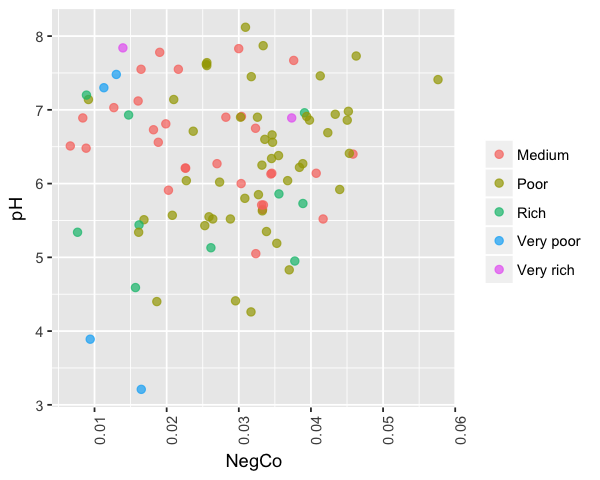

In [87]:
options(repr.plot.width=5, repr.plot.height=4)

df = data.frame(sample_data(ps.norm))
df$NegCo = df$NegativeCohesion*(-1)
df$PosCo = df$PositiveCohesion

p = ggplot(df)
p = p + geom_point(aes(y=pH,x=NegCo,color=Nutrient),width=0.1,alpha=0.7, size=2)

#p = p + ylim(c(0,0.15)) + xlim(c(0,0.06))
p = p + geom_abline(slope=1,intercept=0,linetype=2)
p = p + geom_abline(slope=1000000000000000000,intercept=0)
p = p + geom_abline(slope=0,intercept=0)
#p = p + ylab("Positive Cohesion") + xlab("Negative Cohesion")
p = p + theme(axis.text.x = element_text(angle=90,hjust=1),legend.title=element_blank()) 
p